This project aims to discriminate between **fake** images and **real** ones. This dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) that was provided by Bojan.

# Main Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

2025-04-19 23:27:07.631493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745105227.814267      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745105227.868050      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
tf.keras.backend.clear_session() #clean session

# Data Loading

The paths to the training, validation, and test sets have been specified below.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/140k-real-and-fake-faces


In [ ]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

As we can see, each directory contains two subfolders: fake and real.

In [ ]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


# Short EDA - Exploratory Data Analysis

Create a dictionary with three keys:
* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)    

In [ ]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [ ]:
images_df = pd.DataFrame(images_df)

In [ ]:
images_df

folder                                         image_path label
0       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
1       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
2       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
3       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
4       valid  /kaggle/input/140k-real-and-fake-faces/real_vs...  fake
...       ...                                                ...   ...
139995  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139996  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139997  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139998  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real
139999  train  /kaggle/input/140k-real-and-fake-faces/real_vs...  real

[140000 rows x 3 columns]

### Labels distribution

In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [ ]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [ ]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

As we can see fromt the results, the labels are equally distributed on each folder.

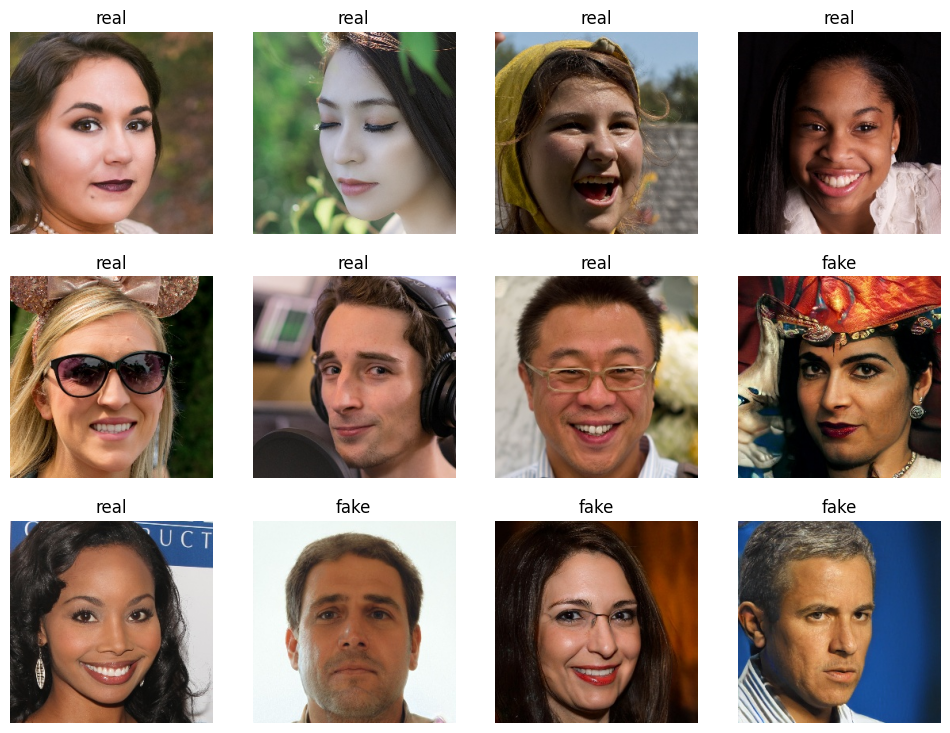

In [ ]:
plt.figure(figsize=(12, 9))


fake_images = images_df.sample(12)
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(plt.imread(fake_images["image_path"].values[i]))
    plt.title(fake_images["label"].values[i])
    plt.axis("off")

# Data Preparation for training

## Data Augmentation

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. Horizontal flip data augmentation is set to True in order to increase the size of a dataset by flipping images horizontally. This can help improve the accuracy of the model by exposing it to additional variations of the same images.

In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

Important! test_ds prediction and train_ds.classes (ground-truth) **will be not alligned** with suffle=True, so I need to disable shuffle for the test set.

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


It's visible that all the value are scaled.

In [ ]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.654902   0.6392157  0.49411768]
  [0.52156866 0.50980395 0.38823533]
  [0.7490196  0.75294125 0.68235296]
  ...
  [0.82745105 0.86666673 0.8705883 ]
  [0.86666673 0.86274517 0.8470589 ]
  [0.75294125 0.7372549  0.7019608 ]]

 [[0.8313726  0.8313726  0.69803923]
  [0.8117648  0.8117648  0.70980394]
  [0.8588236  0.86666673 0.8117648 ]
  ...
  [0.83921576 0.8705883  0.882353  ]
  [0.86274517 0.86666673 0.8470589 ]
  [0.7607844  0.74509805 0.70980394]]

 [[0.8431373  0.8588236  0.7607844 ]
  [0.83921576 0.8705883  0.78823537]
  [0.8352942  0.8705883  0.85098046]
  ...
  [0.7686275  0.7960785  0.8196079 ]
  [0.8196079  0.8196079  0.8117648 ]
  [0.75294125 0.7411765  0.7137255 ]]

 ...

 [[0.13725491 0.11764707 0.09411766]
  [0.10980393 0.09019608 0.06666667]
  [0.11764707 0.09803922 0.08627451]
  ...
  [0.86666673 0.68235296 0.6039216 ]
  [0.854902   0.6862745  0.6117647 ]
  [0.86274517 0.7019608  0.6313726 ]]

 [[0.16078432 0.14509805 0.09803922]
  [0.12941177 0.1137255  0.0

Let's print the input shape:
- 64 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [ ]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [ ]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# CNN model architecture (DenseNet121)

In [ ]:
input_shape = (256, 256, 3) #define the input shape of our data

In [ ]:
#create the model's architecture and compile it
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [ ]:
model_ft = get_model(input_shape)

model_ft.summary()

I0000 00:00:1745105458.724803      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.227672 to fit



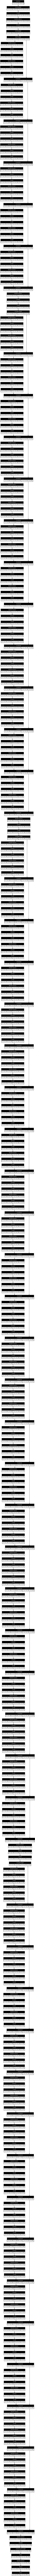

In [ ]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

Let's define the Callbacks

**ModelCheckpoint** callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
In this case, we don't have to worry about training for too long and overfitting the training set.

In [ ]:
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

The **EarlyStopping** callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau** callback reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

# Training

In [ ]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745105584.025329     122 service.cc:148] XLA service 0x7fa3ec005d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745105584.025788     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745105592.695332     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745105678.436835     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1616s 914ms/step - accuracy: 0.8993 - loss: 0.2379 - val_accuracy: 0.5186 - val_loss: 4.0060 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 615s 392ms/step - accuracy: 0.9793 - loss: 0.0560 - val_accuracy: 0.9427 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 611s 390ms/step - accuracy: 0.9836 - loss: 0.0431 - val_accuracy: 0.9062 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 601s 384ms/step - accuracy: 0.9893 - loss: 0.0271 - val_accuracy: 0.6787 - val_loss: 1.5469 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 611s 390ms/step - accuracy: 0.9897 - loss: 0.0281 - val_accuracy: 0.9567 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 613s 391ms/step - accuracy: 0.9916 - loss: 0.0232 - val_accuracy: 0.8856 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 618s 394ms/step - ac

# Results

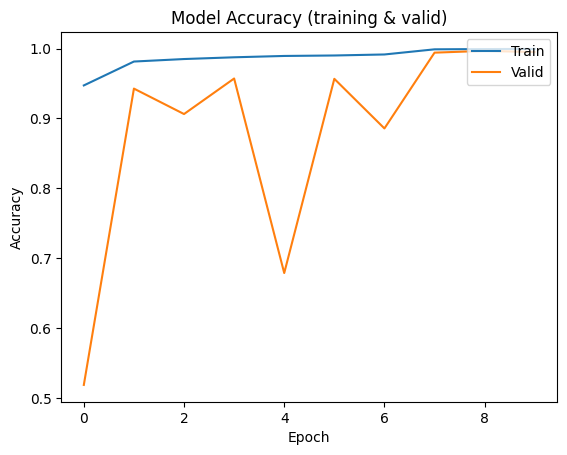

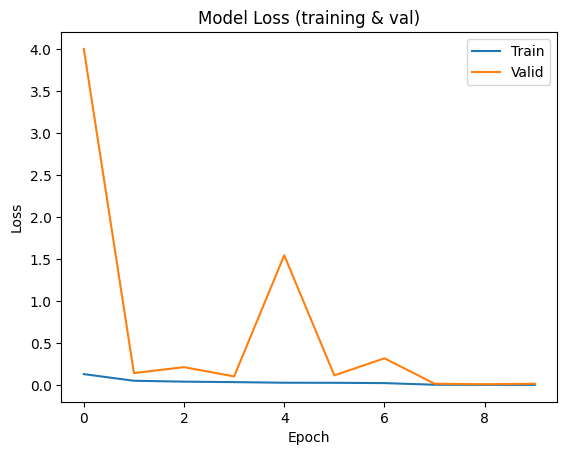

In [ ]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


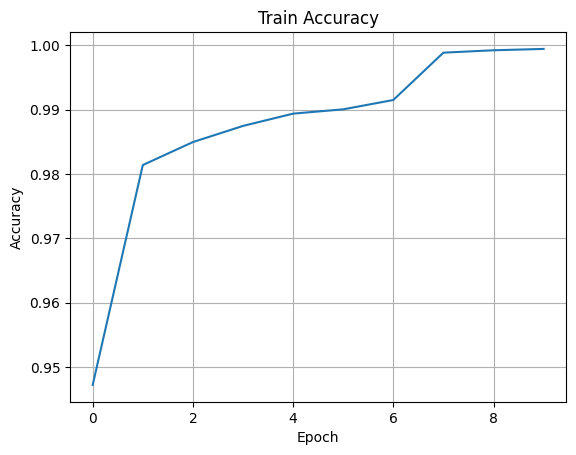

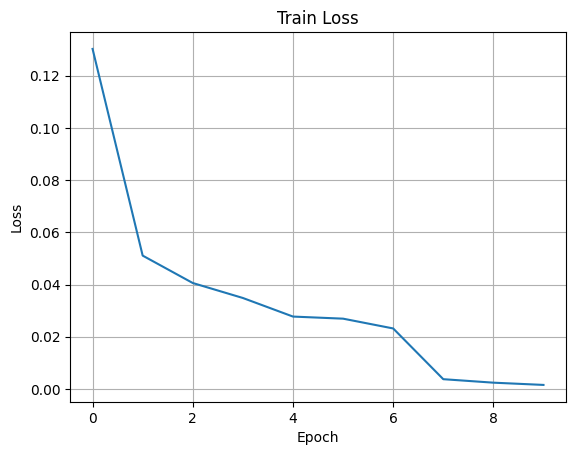

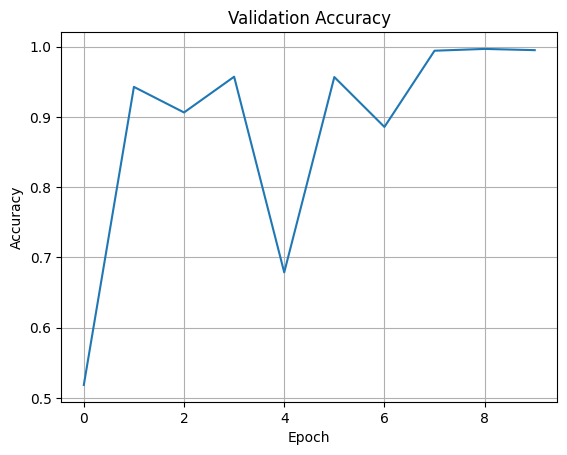

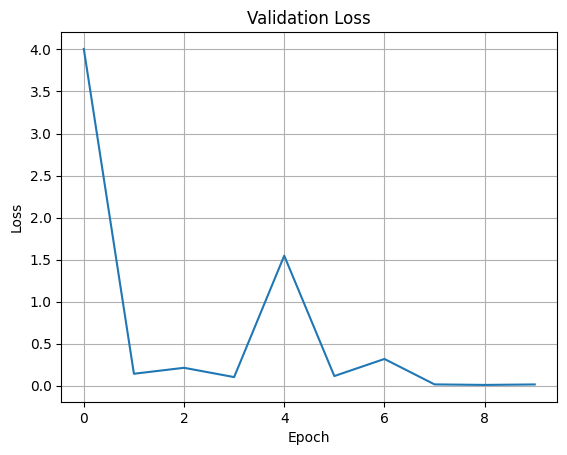

In [ ]:
# Train Accuracy
plt.plot(history_ft.history['accuracy'])
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

# Train Loss
plt.plot(history_ft.history['loss'])
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

# Validation Accuracy
plt.plot(history_ft.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

# Validation Loss
plt.plot(history_ft.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 690ms/step - accuracy: 0.9962 - loss: 0.0108
Test Loss: 0.008891825564205647
Test Accuracy: 0.9968500137329102


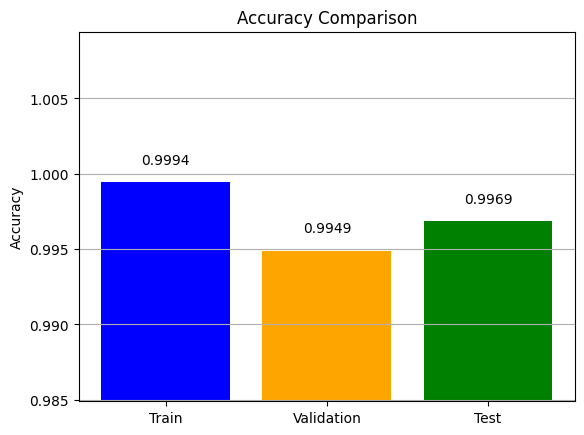

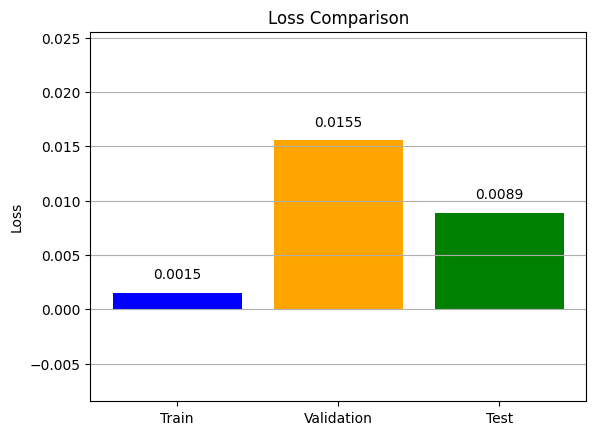

In [ ]:
import matplotlib.pyplot as plt

# Extract final metrics
train_acc = history_ft.history['accuracy'][-1]
val_acc = history_ft.history['val_accuracy'][-1]
train_loss = history_ft.history['loss'][-1]
val_loss = history_ft.history['val_loss'][-1]
test_loss, test_acc = model_ft.evaluate(test_ds, verbose=0)

# Accuracy Bar Plot
acc_values = [train_acc, val_acc, test_acc]
acc_labels = ['Train', 'Validation', 'Test']

plt.bar(acc_labels, acc_values, color=['blue', 'orange', 'green'])
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center', va='bottom')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(min(acc_values) - 0.01, max(acc_values) + 0.01)
plt.grid(axis='y')
plt.show()

# Loss Bar Plot
loss_values = [train_loss, val_loss, test_loss]
loss_labels = ['Train', 'Validation', 'Test']

plt.bar(loss_labels, loss_values, color=['blue', 'orange', 'green'])
for i, v in enumerate(loss_values):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center', va='bottom')
plt.title('Loss Comparison')
plt.ylabel('Loss')
plt.ylim(min(loss_values) - 0.01, max(loss_values) + 0.01)
plt.grid(axis='y')
plt.show()


Here a ModelCheckpoint callback is necessary. Indeed loading the best weights results in a much better performance on the test set.

In [ ]:
model = get_model(input_shape)

# Restore the weights
model.load_weights('model_cp.weights.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 738 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 249ms/step - accuracy: 0.9962 - loss: 0.0108
Test Loss: 0.008891825564205647
Test Accuracy: 0.9968500137329102


# Image example - Qualitative results

Let's try the model on a real image. It is very confident (99.96%) that it is a real one.

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

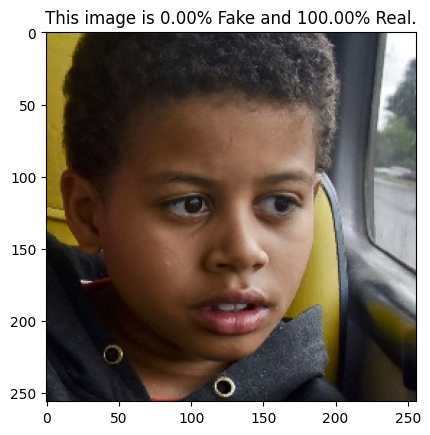

In [ ]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


The result score is near 1 if the image is **real** and 0 if the image is **fake**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Text(0.5, 1.0, 'This image is 100.00% Fake and 0.00% Real.')

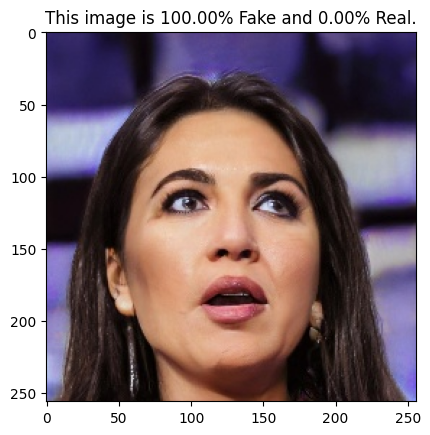

In [ ]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/009ZTJ3621.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

#fake example
test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

# Quantitative results

In [ ]:
# Assuming you have defined your model as 'model'
predicted_labels = model.predict(test_ds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 293ms/step


In [ ]:
true_labels = test_ds.classes

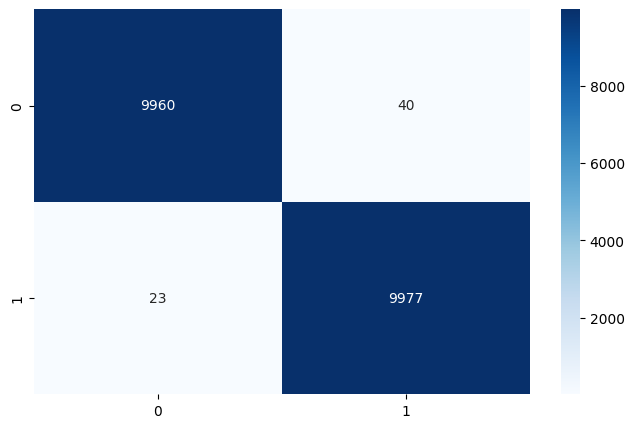

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [ ]:
metrics.accuracy_score(true_labels, predicted_labels.round())

0.99685

# LIME for Explainations

In [ ]:
# Install LIME if not already installed
!pip install lime

from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. Create the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# 2. Define a prediction function for LIME
def predict_fn(images):
    # images: list of HxWx3 numpy arrays with values in [0,255]
    imgs = np.array(images) / 255.0
    preds = model.predict(imgs)            # shape: (N, 1)
    # return probabilities for each class: [fake_prob, real_prob]
    return np.concatenate([1 - preds, preds], axis=1)

## LIME Explaination for Fake Image

  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


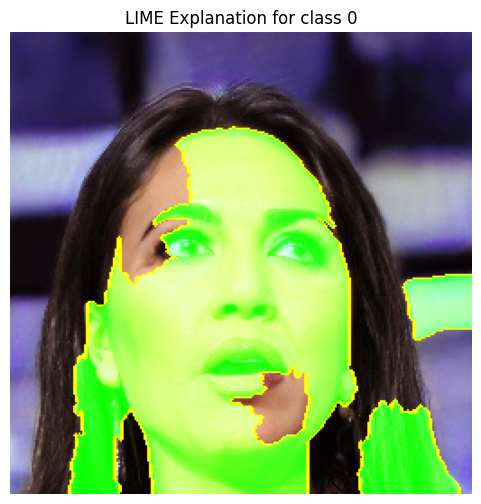

In [ ]:

# 3. Pick one sample image from the test set (disable shuffling)
# img_batch, label_batch = next(iter(test_ds))
# sample_img = (img_batch[0] * 255).astype(np.uint8)   # back to [0,255] uint8

img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/009ZTJ3621.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/01IUWPPCNT.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/03G6VANLKO.jpg'

img = kp_image.load_img(img_path, target_size=(256,256))
sample_img = kp_image.img_to_array(img).astype(np.uint8)

# 4. Generate LIME explanation
explanation = explainer.explain_instance(
    image=sample_img,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000,
    batch_size=64
)

# 5. Visualize the explanation for the top predicted label
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for class {top_label}")
plt.axis('off')
plt.show()


## LIME Explaination for Real Image

  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


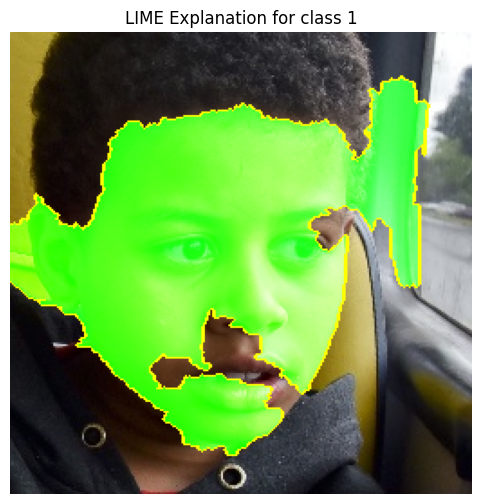

In [ ]:

# 3. Pick one sample image from the test set (disable shuffling)
# img_batch, label_batch = next(iter(test_ds))
# sample_img = (img_batch[0] * 255).astype(np.uint8)   # back to [0,255] uint8

img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00114.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00311.jpg'



img = kp_image.load_img(img_path, target_size=(256,256))
sample_img = kp_image.img_to_array(img).astype(np.uint8)

# 4. Generate LIME explanation
explanation = explainer.explain_instance(
    image=sample_img,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000,
    batch_size=64
)

# 5. Visualize the explanation for the top predicted label
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for class {top_label}")
plt.axis('off')
plt.show()


## LIME Explaination for Random Image from Test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted score: 0.025027964


  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


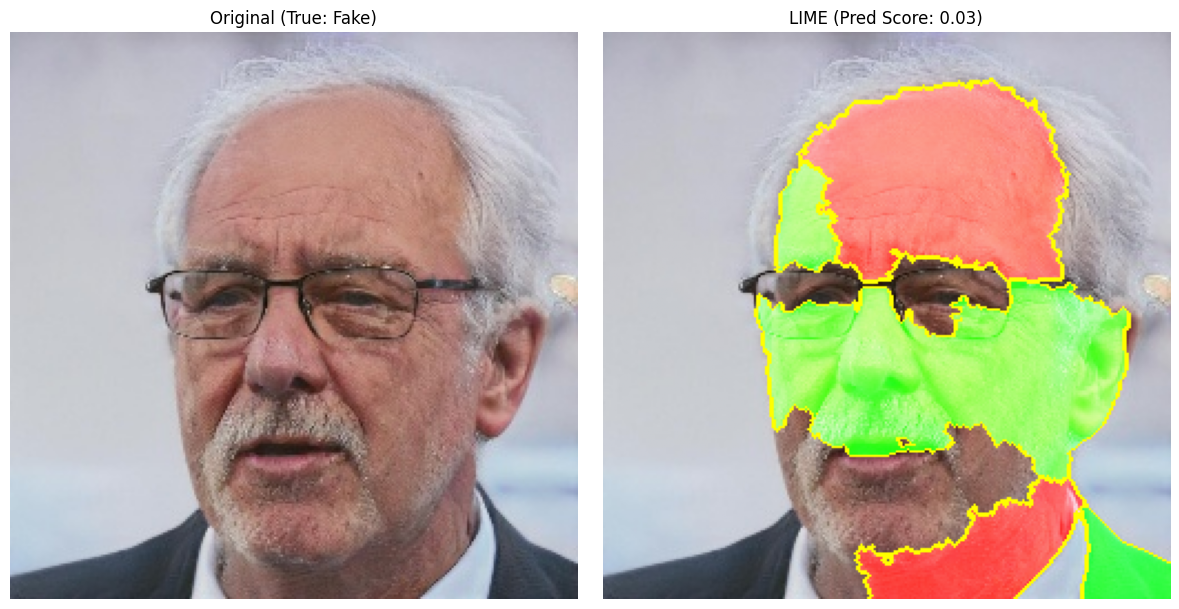

In [ ]:
import tensorflow as tf

# Get a sample image and label from test dataset
img_batch, label_batch = next(iter(test_ds))
sample_img_tensor = img_batch[0]
sample_label = label_batch[0]
sample_img = (sample_img_tensor * 255).astype(np.uint8)

# Get model prediction
preds = model.predict(np.expand_dims(sample_img_tensor, axis=0))
pred_score = preds[0][0]
print("Predicted score:", pred_score)

# Determine predicted class and probability
pred_label = 1 if pred_score >= 0.5 else 0
pred_prob = pred_score if pred_label == 1 else 1 - pred_score

# Get class names
class_names = ['Fake', 'Real']

# Generate LIME explanation
explanation = explainer.explain_instance(
    image=sample_img,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000,
    batch_size=64
)

top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,
    num_features=10,
    hide_rest=False
)

# Plot Original and Explanation
plt.figure(figsize=(12, 6))

# Original Image with True Label
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title(f"Original (True: {class_names[int(sample_label)]})")
plt.axis('off')

# LIME Explanation with Predicted Label
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME (Pred Score: {pred_score:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Grad-Cam for Explainations

In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
# Get the names of all layers in the model.
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

input_layer_1
zero_padding2d_2
conv1_conv
conv1_bn
conv1_relu
zero_padding2d_3
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv

## Grad-Cam Explaination for Fake Image

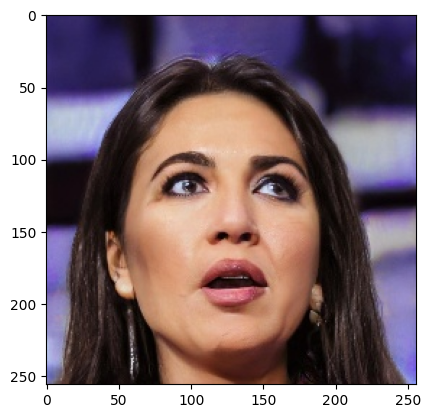

In [ ]:

img_size = (256, 256)


last_conv_layer_name = "conv5_block16_2_conv"

img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/009ZTJ3621.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/01IUWPPCNT.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/03G6VANLKO.jpg'

test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
plt.imshow(test_image)

img = tf.keras.preprocessing.image.img_to_array(test_image)
img = np.expand_dims(img, axis=0)
img = img/255.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: [[4.128134e-07]]


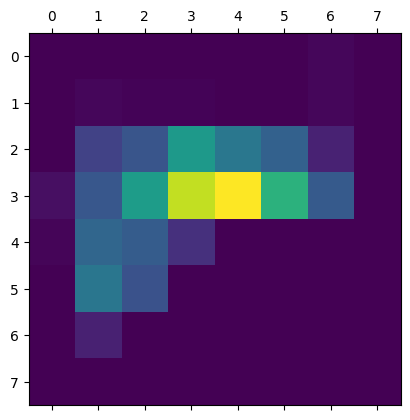

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

# Generate Grad-CAM++ heatmap
heatmap = make_gradcam_heatmap(img, model, "conv5_block16_2_conv")

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_31/1896598370.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


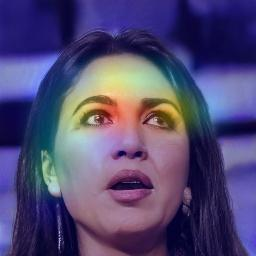

In [ ]:
save_and_display_gradcam(img_path, heatmap)

## Grad-Cam Explaination for Real Image

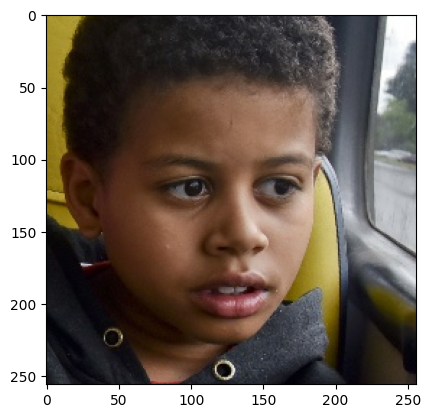

In [ ]:

img_size = (256, 256)


last_conv_layer_name = "conv5_block16_2_conv"

img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00114.jpg'
# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00311.jpg'

test_image = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
plt.imshow(test_image)

img = tf.keras.preprocessing.image.img_to_array(test_image)
img = np.expand_dims(img, axis=0)
img = img/255.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: [[1.]]


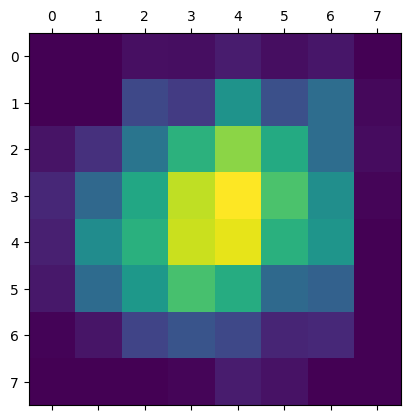

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

# Generate Grad-CAM++ heatmap
heatmap = make_gradcam_heatmap(img, model, "conv5_block16_2_conv")

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_31/1896598370.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


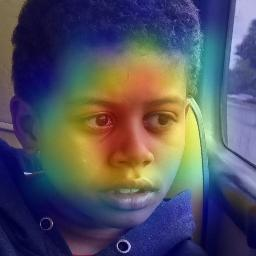

In [ ]:
save_and_display_gradcam(img_path, heatmap)

## Grad-Cam Explaination for Random Image from Test data

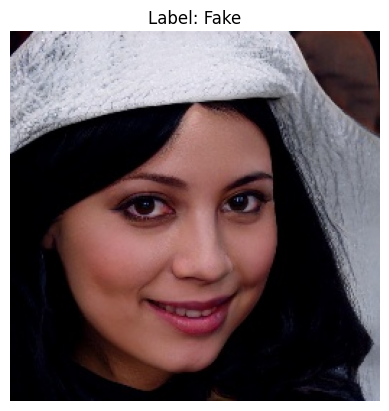

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: [[0.00010961]]


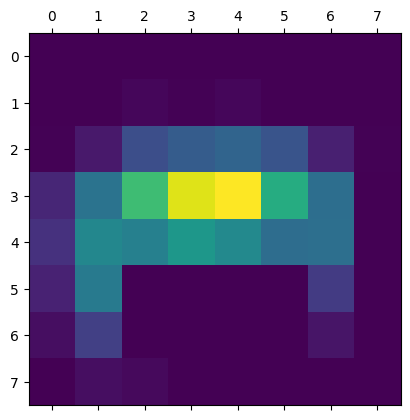

/tmp/ipykernel_31/1896598370.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


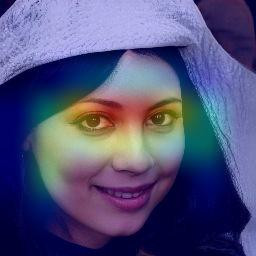

In [ ]:
# Pick one sample image from the test set
img_batch, label_batch = next(iter(test_ds))
sample_img = img_batch[0]  # Already scaled to [0, 1]
sample_img_uint8 = (sample_img * 255).astype(np.uint8)

# Display the image
plt.imshow(sample_img)
plt.axis('off')
plt.title(f"Label: {'Real' if label_batch[0] == 1 else 'Fake'}")
plt.show()

# Prepare for Grad-CAM
img = np.expand_dims(sample_img, axis=0)

# Remove last layer's softmax if necessary
model.layers[-1].activation = None

# Predict class
preds = model.predict(img)
print("Predicted:", preds)

# Generate Grad-CAM heatmap
last_conv_layer_name = "conv5_block16_2_conv"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad-CAM overlaid image
# You can temporarily save sample_img to disk or modify the function to work directly with arrays
from PIL import Image as PILImage

# Convert array to image and save temporarily
sample_img_pil = PILImage.fromarray(sample_img_uint8)
sample_img_pil.save("sample_test_img.jpg")

save_and_display_gradcam("sample_test_img.jpg", heatmap)
